# Use Change Detection

This notebook uses the float framework to load a binary classification data set, train two change detectors, namely the ERICS change detector and the ADWIN change detector from the scikit-multiflow library, and train a HoeffdingTree classifier also from the scikit-multiflow library. This is done using float's PrequentialPipeline. The zero-one loss and the change detectors' mean time ratio are used as evaluation metrics and are plotted over all time steps. Additionally, the known and detected drifts are shown in a scatter plot for both change detectors.

In [1]:
import os
os.chdir(os.getcwd()[:-6])

In [2]:
from float.data import DataLoader
from float.change_detection import ERICS
from float.change_detection.evaluation import ChangeDetectionEvaluator
from float.change_detection.evaluation.measures import mean_time_ratio
from float.change_detection.skmultiflow import SkmultiflowChangeDetector
from float.pipeline import PrequentialPipeline
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.visualization import plot, concept_drifts_scatter
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.trees import HoeffdingTreeClassifier

In [3]:
data_loader = DataLoader(path='float/data/datasets/spambase.csv', target_col=-1)

known_drifts = [round(data_loader.stream.n_samples * 0.2), round(data_loader.stream.n_samples * 0.4),
                round(data_loader.stream.n_samples * 0.6), round(data_loader.stream.n_samples * 0.8)]

predictor = SkmultiflowClassifier(HoeffdingTreeClassifier(), data_loader.stream.target_values, reset_after_drift=True)
pred_evaluator = PredictionEvaluator([zero_one_loss], decay_rate=0.1, window_size=10)

change_detectors = [SkmultiflowChangeDetector(ADWIN(delta=0.6), reset_after_drift=False),
                           ERICS(data_loader.stream.n_features)]
cd_evaluators = [ChangeDetectionEvaluator(measure_funcs=[mean_time_ratio],
                                        known_drifts=known_drifts,
                                        batch_size=10,
                                        n_total=data_loader.stream.n_samples,
                                        n_delay=list(range(100, 1000)),
                                        n_init_tolerance=100)
               for i in range(2)]
for i in range(2):
    prequential_pipeline = prequential_pipeline = PrequentialPipeline(data_loader=data_loader,
                                               change_detector=change_detectors[i],
                                               change_detection_evaluator=cd_evaluators[i],
                                               predictor=predictor,
                                               prediction_evaluator=pred_evaluator,
                                               batch_size=10,
                                               n_max=data_loader.stream.n_samples - 10,
                                               known_drifts=known_drifts,)
    prequential_pipeline.run()

Pretrain the predictor with 100 observation(s).
[====================] 100%, No. of detected drifts: 3, Last detected drift at t=255.
################################## SUMMARY ##################################
Evaluation has finished after 10.295133590698242s
Data Set float/data/datasets/spambase.csv
The pipeline has processed 4591 instances in total, using batches of size 10.
----------------------
Concept Drift Detection:
| Model   |   Avg. Comp. Time | Detected Global Drifts   |   Avg. mean_time_ratio |
|---------|-------------------|--------------------------|------------------------|
| ADWIN   |       0.000649884 | [95, 159, 255]           |               0.236072 |
----------------------
Prediction:
| Model                   |   Avg. Test Comp. Time |   Avg. Train Comp. Time |   Avg. zero_one_loss |
|-------------------------|------------------------|-------------------------|----------------------|
| HoeffdingTreeClassifier |              0.0082728 |               0.0108473 | 

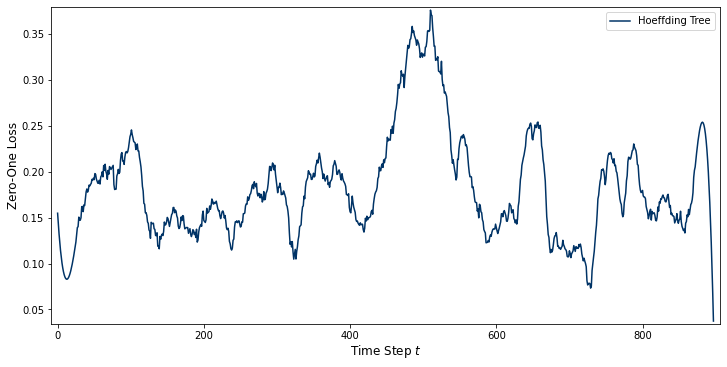

In [4]:
plot(measures=[pred_evaluator.result['zero_one_loss']['measures']],
     labels=['Hoeffding Tree'],
     measure_name='Zero-One Loss',
     measure_type='prediction',
     smooth_curve=[True])
plt.show()

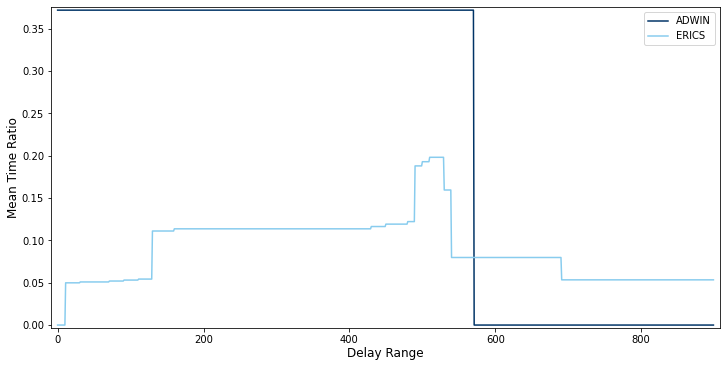

In [5]:
plot(measures=[cd_evaluators[0].result['mean_time_ratio']['measures'], cd_evaluators[1].result['mean_time_ratio']['measures']],
     labels=['ADWIN', 'ERICS'],
     measure_name='Mean Time Ratio',
     measure_type='change_detection')
plt.show()

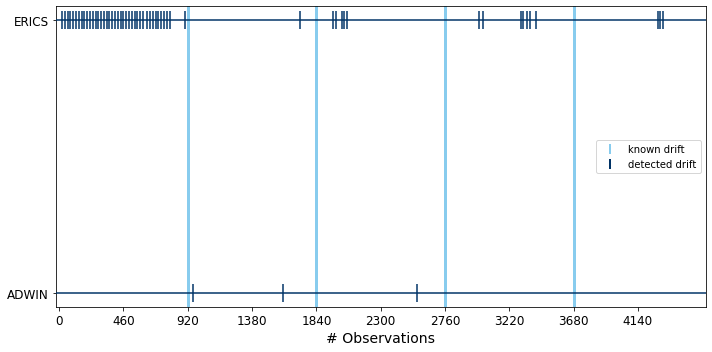

In [6]:
concept_drifts_scatter(measures=[change_detectors[0].drifts, change_detectors[1].drifts],
                       labels=['ADWIN', 'ERICS'],
                       measure_type='change_detection',
                       data_stream=data_loader.stream,
                       known_drifts=known_drifts,
                       batch_size=10)
plt.show()